# ETL Process for CFD App

The objective for this notebook is to detailed the necesary ETL process to feed data to a Machine Learning application to support CFD's investors.

The data is going to be extracted using [Alpha Vantage API](https://www.alphavantage.co/documentation/)

For the ML application is going to be necesary:
1. Extract historical data of stocks, transform it into features and store for training and testing of models.
2. Define the modules to be used when querying from the app for data extraction a transformation into features for prediction.

## 1. Historical Data

In [1]:
import pandas as pd
import numpy as np
import requests
import re
from sqlalchemy import create_engine
import time

For queriying the daily price time series from a stock through the API we do the following call

In [2]:
stock = 'TSLA' # symbol of the stock of interest, in this case Tesla Motors, Inc.
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+stock+'&apikey=F0UT6370FXK949PA'
r = requests.get(url)
data = r.json()

data

{'Meta Data': {'1. Information': 'Daily Time Series with Splits and Dividend Events',
  '2. Symbol': 'TSLA',
  '3. Last Refreshed': '2021-10-20',
  '4. Output Size': 'Compact',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2021-10-20': {'1. open': '865.35',
   '2. high': '869.49',
   '3. low': '857.38',
   '4. close': '865.8',
   '5. adjusted close': '865.8',
   '6. volume': '14032052',
   '7. dividend amount': '0.0000',
   '8. split coefficient': '1.0'},
  '2021-10-19': {'1. open': '877.53',
   '2. high': '877.95',
   '3. low': '862.51',
   '4. close': '864.27',
   '5. adjusted close': '864.27',
   '6. volume': '17381128',
   '7. dividend amount': '0.0000',
   '8. split coefficient': '1.0'},
  '2021-10-18': {'1. open': '851.79',
   '2. high': '875.26',
   '3. low': '851.47',
   '4. close': '870.11',
   '5. adjusted close': '870.11',
   '6. volume': '24207244',
   '7. dividend amount': '0.0000',
   '8. split coefficient': '1.0'},
  '2021-10-15': {'1. open': '823.7384',
   

Let's now explore the retrieved data

In [3]:
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [4]:
df = pd.DataFrame.from_dict(data = data['Time Series (Daily)'], orient='index')
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-10-20,865.35,869.49,857.38,865.8,865.8,14032052,0.0000,1.0
2021-10-19,877.53,877.95,862.51,864.27,864.27,17381128,0.0000,1.0
2021-10-18,851.79,875.26,851.47,870.11,870.11,24207244,0.0000,1.0
2021-10-15,823.7384,843.21,822.35,843.03,843.03,18924567,0.0000,1.0
2021-10-14,815.49,820.25,813.3501,818.32,818.32,12247170,0.0000,1.0


In [5]:
df.shape

(100, 8)

Detected field types by default.

In [6]:
df.dtypes

1. open                 object
2. high                 object
3. low                  object
4. close                object
5. adjusted close       object
6. volume               object
7. dividend amount      object
8. split coefficient    object
dtype: object

Percentage of null entries by field.

In [7]:
df.isnull().mean()

1. open                 0.0
2. high                 0.0
3. low                  0.0
4. close                0.0
5. adjusted close       0.0
6. volume               0.0
7. dividend amount      0.0
8. split coefficient    0.0
dtype: float64

We can identify that there are no null values in the data but the dtype does need to be adjusted

By default the API call only retrieves the last 100 data points in the series, ideally this would be enough to make a prediction, but 100 trading days back may not be enough of a look to the past we won't be able to provide sufficient data to make a good prediction, so we are going to consider also another time series.

So for that we are going to use the following function.

In [8]:
def load_series(symbol, frequency, outputsize = 'compact'):
    """
    Load time serie from the stock symbol with the defined frequency and outputsize.
    
    IN:
    symbol -- stock's symbol to get the data.
    frequency -- either dayly, weekly or monthly data to be retrieved.
    outputsize -- by default compact for last 100 data points in the series or 
                  full for the complete 20+ years of historical data.
    
    OUT: pandas dataframe with the following columns:
    open -- opening price on the period.
    high -- maximun price during the period.
    low -- minimum price during the period.
    close -- closing price on the period.
    adjuste close -- adjusted closing price on the period.
    volume -- number of negotiations during the period.
    """
    
    # function dictionary for different time series in the API
    freq_funct_dict = {'daily':'TIME_SERIES_DAILY_ADJUSTED',
                       'weekly':'TIME_SERIES_WEEKLY_ADJUSTED',
                       'monthly':'TIME_SERIES_MONTHLY_ADJUSTED'}
    
    # define the url to make the request
    url = 'https://www.alphavantage.co/query?function='+freq_funct_dict[frequency]+'&symbol='+symbol \
        +'&outputsize='+outputsize+'&apikey=F0UT6370FXK949PA'
    
    r = requests.get(url)
    data = r.json()
    
    # build dataframe from data dictionary
    df = pd.DataFrame.from_dict(data = data[list(data.keys())[1]], orient='index')
    
    # adjust columns types and names
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    rem_dig = lambda x : re.sub('[1-9]. ', '', x)
    df.columns = [rem_dig(x) for x in df.columns]
    
    df = df.reset_index()
    df['index'] = pd.to_datetime(df['index'])
    
    # add individual date related features for merging different frequency data
    df['year'] = df['index'].dt.year
    df['month'] = df['index'].dt.month
    df['week'] = df['index'].dt.isocalendar().week
    
    df = df.set_index('index')
    
    out_cols = ['open',
                'high',
                'low',
                'close',
                'adjusted close',
                'volume',
                'year',
                'month',
                'week']
    return df[out_cols]
    

### Function testing

Let's try our new function with several frequencies and symbols

In [9]:
df = load_series('TSLA', 'monthly')
df.head()

,open,high,low,close,adjusted close,volume,year,month,week
index,,,,,,,,,
2021-10-20,778.40,877.95,763.59,865.80,865.80,253647132,2021,10,42
2021-09-30,734.08,799.00,708.85,775.48,775.48,390215611,2021,9,39
2021-08-31,700.00,740.39,648.84,735.72,735.72,381913604,2021,8,35
2021-07-30,683.92,700.00,620.46,687.20,687.20,447786560,2021,7,30
2021-06-30,627.80,697.62,571.22,679.70,679.70,519623430,2021,6,26


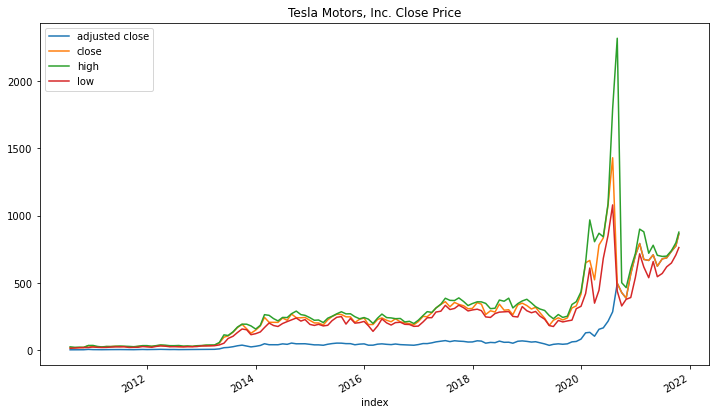

In [10]:
df[['adjusted close', 'close', 'high', 'low']].sort_index().plot(kind = 'line',
                 figsize = (12,7),
                 title = 'Tesla Motors, Inc. Close Price');

In [11]:
df.shape

(136, 9)

In [12]:
df = load_series('AAPL', 'weekly')
df.head()

,open,high,low,close,adjusted close,volume,year,month,week
index,,,,,,,,,
2021-10-20,143.445,149.7539,143.1600,149.26,149.26,220386857,2021,10,42
2021-10-15,142.270,144.8950,139.2000,144.84,144.84,354098233,2021,10,41
2021-10-08,141.760,144.2150,138.2700,142.90,142.90,382910000,2021,10,40
2021-10-01,145.470,145.9600,139.1101,142.65,142.65,441421358,2021,10,39
2021-09-24,143.800,147.4701,141.2700,146.92,146.92,394033205,2021,9,38


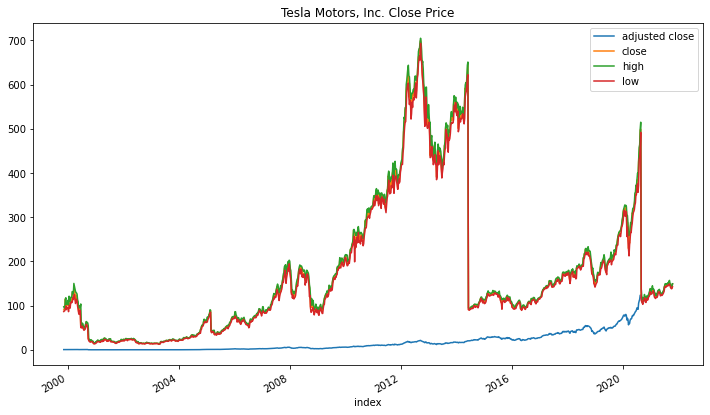

In [13]:
df[['adjusted close', 'close', 'high', 'low']].sort_index().plot(kind = 'line',
                 figsize = (12,7),
                 title = 'Tesla Motors, Inc. Close Price');

In [14]:
df.shape

(1146, 9)

## Selection of the data for modeling

To begin with we will support only 4 stocks, mainly because each stock will have it's independent scale and scaling across all stock may impact predicting performance, this means that for each stock we will need classifier/regressor object and in terms of space for the web app may rise some problems.

The choosen stocks are the ones, at the moment of construction, the most traded ones i.e. the ones with the highest volumes ([Yahoo Finance](https://finance.yahoo.com/most-active)).

1. FuelCell Energy, Inc.
2. Apple Inc.
3. Bank of America Corporation.
4. Macy's, Inc.

With the chosen stocks lets now saved all frequency data for further modeling.

In [20]:
stock_dict = {'BAC':'Bank of America Corporation.',
              'M':"Macy's, Inc.",
              'FCEL':'FuelCell Energy, Inc.',
              'AAPL':'Apple Inc.'}

#stock_dict = {'AAPL':'Apple Inc.'}

def save_stock_data(database_filename):
    """
    Save the stock data in the defined database_filename
    """
    engine = create_engine('sqlite:///'+database_filename)
    for key in stock_dict.keys():
        for freq in ['daily', 'weekly', 'monthly']:
            if freq == 'daily':
                outputsize = 'full'
            else:
                outputsize = 'compact'
            df = load_series(key, freq, outputsize)
            df.to_sql(key+'_'+freq, engine, if_exists = 'replace')
            print(df.shape)
            print('Saved {} data for {}'.format(freq, stock_dict[key]))
            sleep(15) # the API would saturate if to many request to fast
        print('\n')
        sleep(30) # the API would saturate if to many request to fast
    print('..Saved succesfull for all stocks!')
    
## In case of API saturation run process one stock at a time.

In [21]:
save_stock_data('stock_price.db')

(5529, 9)
Saved daily data for Apple Inc.
(1146, 9)
Saved weekly data for Apple Inc.
(263, 9)
Saved monthly data for Apple Inc.


..Saved succesfull for all stocks!
